In [2]:
#set xla parameters for using gpu
# %env XLA_PYTHON_CLIENT_PREALLOCATE=false
# %env XLA_PYTHON_CLIENT_ALLOCATOR=platform
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=.99
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
from scipy.optimize import minimize

import jax
#use 64 bit floats
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit, vmap
import jax.scipy as jsp
from functools import partial
import matplotlib
from tqdm.auto import tqdm
import optimistix as optx

import drpangloss.oifits_implaneia as oifits
from drpangloss.oifits_implaneia import load_oifits, cp_indices

from drpangloss.models import *
from drpangloss.grid_fit import *

/var/folders/vx/lm_q_1ld7c13_fbqfscs9n4w0000gq/T/ipykernel_50389/3061761905.py:16: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config; config.update("jax_enable_x64", True)


In [3]:
plt.figure()
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 14})

<Figure size 640x480 with 0 Axes>

In [4]:
fn = "NuHor_F480M.oifits"
dr = "../data/"
cp,cp_err,vis2,vis2_err,u,v,i_cps1,i_cps2,i_cps3=load_oifits(fn,dr)

In [5]:
rad2mas = 180./np.pi*3600.*1000. # convert rad to mas
mas2rad = np.pi/180./3600./1000. # convert mas to rad

In [6]:
#define a function to calculate a log likelihood grid 
inner_fun = partial(vmap(log_like_binary, in_axes=(None,None,None,None,None,None,None,None,None,0,0,None)))
outer_fun = partial(vmap(inner_fun, in_axes=(None,None,None,None,None,None,None,None,None,None,None,0)))
log_like_binary_map = jit(outer_fun)

In [7]:
#calculate ra/dec grid
dx = 5
ra_dec_grid,_ = get_grid(sep_range=[10.,600.], step_size=dx, verbose=False)
#size of grid
nx = ra_dec_grid[0].shape[0]
nb = u.shape
dra  = ra_dec_grid[0].flatten()
ddec = ra_dec_grid[1].flatten()
#number of contrasts to calculate
nconts = 100
planet_contrast = 10**np.linspace(-6,-1,nconts)

#simulate cvis data - overwrite loaded nu hor data for now
ddec_inp = 150
dra_inp = 150
simulated_data = True
p_inj_cont = 5e-4
if simulated_data:
    cvis = vis_binary(u, v, ddec=ddec_inp,dra=dra_inp,planet=p_inj_cont)
    cp = closure_phases(cvis,i_cps1,i_cps2,i_cps3)
    #add uncorrelated gaussian noise
    cp += np.random.normal(0,cp_err)
    vis2 = jnp.abs(cvis)**2
    vis2 += np.random.normal(0,vis2_err)
    d_cp = cp_err.copy()
    d_vis2 = vis2_err.copy()
else:
    d_cp = jnp.sqrt(cp_err.copy()**2+np.std(cp)**2)
    d_vis2 = jnp.sqrt(vis2_err.copy()**2+np.std(vis2)**2)

# Grid Search
Create a log likelihood map over a grid of ra, dec, contrast, with the contrast that maximizes the likelihood.

In [8]:
ll_map = log_like_binary_map(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,planet_contrast)
#reshape likelihood map into number of contrasts , image size
ll_map_rs = ll_map.reshape(nconts,nx,nx) 
#save indices from grid fit for initialization of contrast fit
inds_cont = np.argmax(ll_map_rs,axis=0)
max_ll_map = jnp.nanmax(ll_map_rs,axis=0)
mask = 0.*max_ll_map #define an additive nan mask

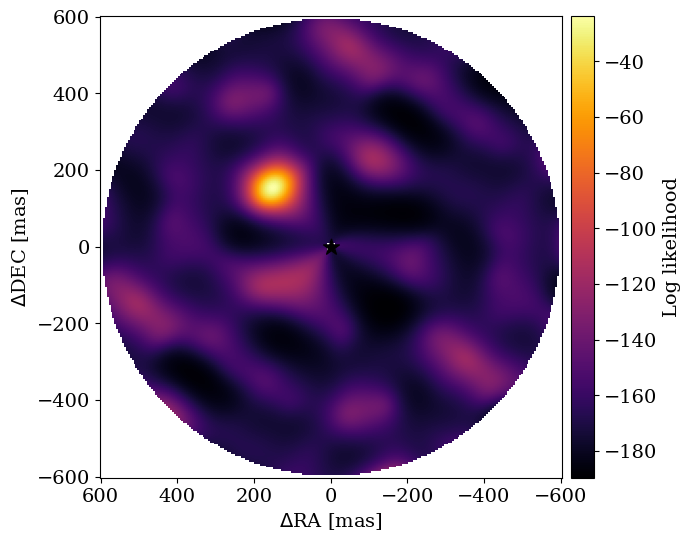

In [9]:
plt.figure(figsize=(12,6))
plt.imshow(max_ll_map,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None,alpha=1)
plt.colorbar(shrink=1,label='Log likelihood', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
#plt.scatter(dra_inp,ddec_inp, 
#            s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
plt.gca().invert_yaxis()
plt.show()

In [10]:

#define a function to find the contrast that maximizes the log likelihood
vmap_fun = partial(vmap(optimize_log_like, in_axes=(None,None,None,None,None,None,None,None,None,0,0,0)))
optimize_log_like_map = jit(vmap_fun)

# Use gradient based optimization to find the local minima from the grid search.

In [11]:
contrasts = optimize_log_like_map(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,
                                  planet_contrast[inds_cont].flatten()+ mask.flatten())
contrasts_rs = contrasts.reshape(nx,nx) + mask

This implementation does not make sense because the contrast at each pixel pepends on the contrast at all other pixels so is not a true upper limit.  

We would have to do image reconstruction for this - need a model comparison approach

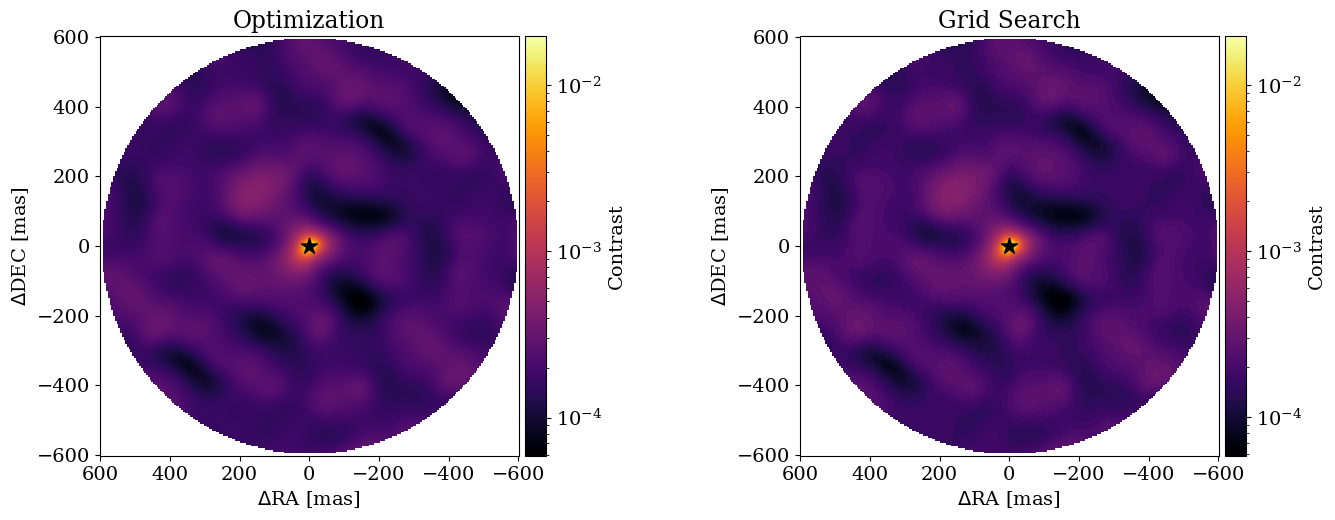

In [12]:
plt.figure(figsize=(14,5))
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
plt.imshow(contrasts_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.title('Optimization')
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(planet_contrast[inds_cont]+mask,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None,alpha=1, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.title('Grid Search')
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.)
plt.show()

In [14]:
#define a function to find the contrast that maximizes the log likelihood
vmap_fun = partial(vmap(sigma, in_axes=(None,None,None,None,None,None,None,None,None,0,0,0)))
sigma_map = jit(vmap_fun)

## Laplace variances

Use the Laplace approximation to calculate the variances on the best fit contrasts in each grid cell.

In [15]:
sigmas = sigma_map(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,contrasts_rs.flatten())
sigmas_rs = sigmas.reshape(nx,nx) + mask

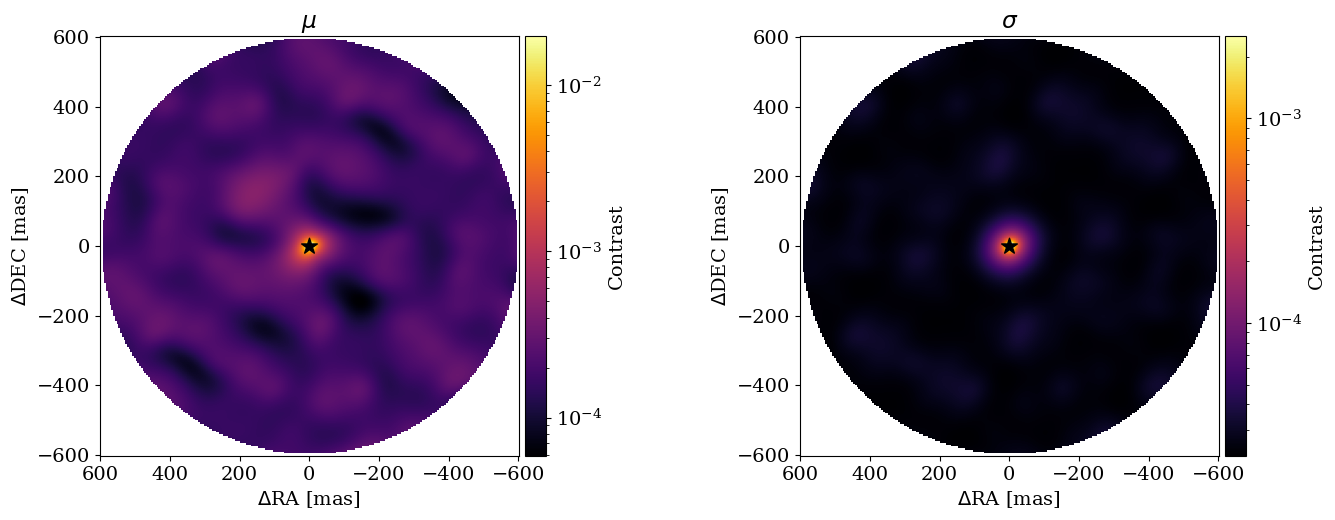

In [16]:
plt.figure(figsize=(14,5))
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
plt.imshow(contrasts_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.title('$\\mu$')
#plt.scatter(dra_inp,ddec_inp, 
#            s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(sigmas_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None,alpha=1, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.title('$\\sigma$')
#plt.scatter(dra_inp,ddec_inp, 
#            s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.)
plt.show()

# Make a naive SNR map

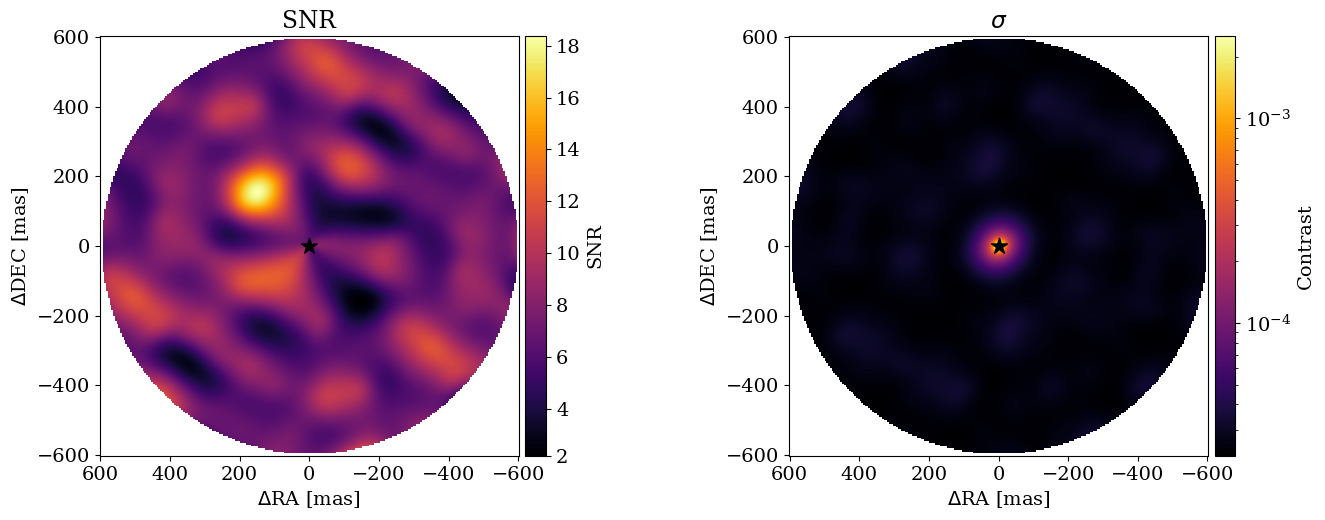

In [17]:
plt.figure(figsize=(14,5))
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
plt.imshow(contrasts_rs/sigmas_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None, norm=matplotlib.colors.PowerNorm(1))
plt.colorbar(shrink=1,label='SNR', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.title('SNR')
#plt.scatter(dra_inp,ddec_inp, 
#            s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(sigmas_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None,alpha=1, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.title('$\\sigma$')
#plt.scatter(dra_inp,ddec_inp, 
#            s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.)
plt.show()

In [18]:
@partial(vmap, in_axes=(0,0,None))
@partial(vmap, in_axes=(None,None,0))
def calc_upperlimit(mean,sigma,percentile):

    #eqn 8 from Ruffio+2018
    limit = jsp.stats.norm.ppf((percentile+(1-percentile)*jsp.stats.norm.cdf(0,loc=mean,scale=sigma)),loc=mean,scale=sigma)

    return limit

In [19]:
perc = jnp.array([jsp.stats.norm.cdf(2.)])
limits = calc_upperlimit(contrasts_rs.flatten(),sigmas_rs.flatten(),perc)
limits_rs = limits.reshape(nx,nx,perc.shape[0])
rad_wdith, avg_wdith  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:,0]), returnradii=True, binsize=2, stddev=False)
_, std_wdith  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:,0]), returnradii=True, binsize=2, stddev=True)

/Users/benpope/opt/anaconda3/envs/pan/lib/python3.11/site-packages/drpangloss/grid_fit.py:126: RuntimeWarning: invalid value encountered in scalar divide
  radial_prof = np.array([(image*weights).flat[whichbin==b].sum() / weights.flat[whichbin==b].sum() for b in range(1,nbins+1)])
/Users/benpope/opt/anaconda3/envs/pan/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/benpope/opt/anaconda3/envs/pan/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/benpope/opt/anaconda3/envs/pan/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Calculate upper limits.

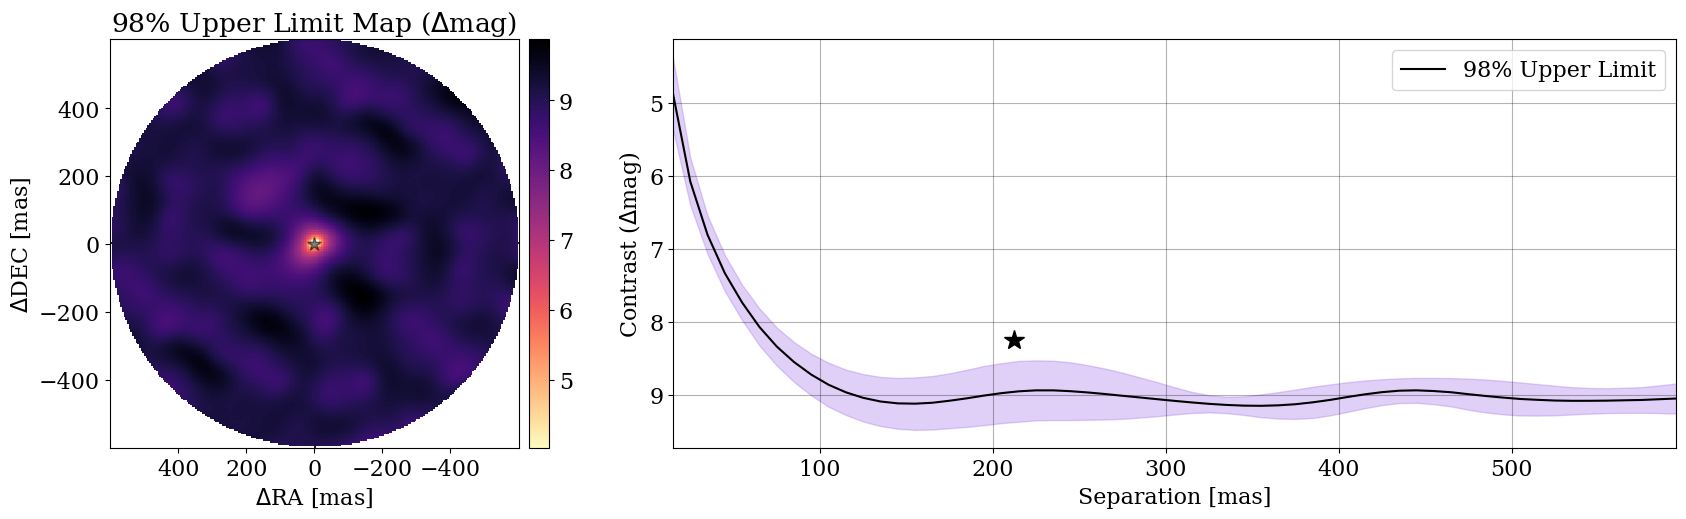

In [20]:
plt.figure(figsize=(20,5))
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 16})
plt.subplot(1,2,1)
plt.imshow(-2.5*jnp.log10(limits_rs[:,:,-1]),cmap=matplotlib.colormaps['magma_r'],
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = 'None',alpha=1)
plt.colorbar(shrink=1, pad=0.01)
plt.scatter(0,0,marker='*',s=100,c='black',alpha=0.5)
plt.gca().invert_yaxis()
plt.title('98% Upper Limit Map ($\\Delta$mag)')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.xticks([400,200,0,-200,-400])
plt.yticks([-400,-200,0,200,400])
plt.subplot(1,2,2)
plt.plot(rad_wdith*dx,avg_wdith,'-k',label="98% Upper Limit")
plt.fill_between(rad_wdith*dx,avg_wdith - std_wdith,avg_wdith + std_wdith,color=(0.6,0.4,0.9),alpha=0.3)
plt.ylabel('Contrast ($\\Delta$mag)')
plt.xlabel('Separation [mas]')
plt.gca().invert_yaxis()
plt.xlim(np.nanmin(rad_wdith*dx+avg_wdith*0.),np.nanmax(rad_wdith*dx+avg_wdith*0.))
plt.grid(color='black',alpha=0.3)
plt.legend(loc='best')
plt.tight_layout(pad=0.)
plt.plot(jnp.sqrt(ddec_inp**2+dra_inp**2),-2.5*jnp.log10(p_inj_cont),marker='*',c='k',markersize=15)
plt.show()

In [21]:
#size = 10_000_000
#xs = np.logspace(-15,0,size)
#ppf_arr = np.zeros(size)
#for i in tqdm(range(size)):
#    ppf_arr[i] = stats.chi2.ppf(1-xs[i],1)
#np.save("chi2_ppf", ppf_arr)
#np.save("chi2_ppf_xs", xs)

In [22]:
ppf_arr = np.load("../data/chi2_ppf.npy")
xs = np.load("../data/chi2_ppf_xs.npy")

In [23]:
def chi2_binary(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,planet_contrast):
    #adapted from pymask
    ''' Calculate the unnormalized log-likelihood of an unresolved binary star model
    ----------------------------------------------------------------
    - ddec = companion dec offset (mas)
    - dra = companion ra offset (mas)
    - cp = closure phases (deg)
    - d_cp = closure phase uncertainty (deg)
    - vis2 = squared visibilties 
    - d_vis2 = squared visibilty uncertainty 
    - planet_contrast = planet
    - u,v: baseline coordinates (wavelengths)
    ---------------------------------------------------------------- '''

    cvis_model = vis_binary(u, v, ddec,dra,planet_contrast)
    
    #calculate model observables
    cp_obs = closure_phases(cvis_model,i_cps1,i_cps2,i_cps3)
    vis2_obs = jnp.abs(cvis_model)**2
    
    ll_cp = jnp.sum((cp_obs-cp)**2/d_cp**2)
    ll_vis2 = jnp.sum((vis2_obs-vis2)**2/d_vis2**2)
    
    return (ll_cp+ll_vis2)

In [24]:
def nsigma_wrap(planet_contrast,u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,xs,ppf_arr,ndof,sigma):

    #constraints
    planet_contrast = jnp.where(planet_contrast<1e-6,1e-6,planet_contrast)
    planet_contrast = jnp.where(planet_contrast>1.,1.,planet_contrast)

    chi2_s = chi2_binary(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, 0.,0.,0.)/ndof 
    chi2_b = chi2_binary(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,planet_contrast)/ndof

    q = jsp.stats.chi2.cdf(ndof*chi2_b/chi2_s, ndof)
    p = 1.-q

    nsigma = jnp.sqrt(jnp.interp(p,xs,ppf_arr))

    nsigma_overflow = jnp.sqrt(jnp.interp(1e-15,xs,ppf_arr))

    nsigmavar = jnp.where(p<1e-15,nsigma_overflow,nsigma)

    return (sigma-nsigmavar)**2

def optimize_nsigma(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,planet_contrast,xs,ppf_arr,ndof,sigma):
    
    sol = optx.compat.minimize(nsigma_wrap,method='BFGS',
                                x0=jnp.array([planet_contrast]), args=(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,xs,ppf_arr,ndof,sigma),options={"maxiter":100})
    
    res = sol.x

    return res

#define a function to find the contrast that maximizes the log likelihood
vmap_fun = partial(vmap(optimize_nsigma, in_axes=(None,None,None,None,None,None,None,None,None,0,0,0,None,None,None,None)))
optimize_nsigma_map = jit(vmap_fun)

In [25]:
#define a function to calculate a log likelihood grid 
inner_fun = partial(vmap(nsigma_wrap, in_axes=(None,None,None,None,None,None,None,None,None,None,0,0,None,None,None,None)))
outer_fun = partial(vmap(inner_fun, in_axes=(0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None)))
nsigma_wrap_map = jit(outer_fun)

In [26]:
ndof = len(cp.flatten())+len(vis2.flatten())
sigma = 5.
nsigma_map = nsigma_wrap_map(planet_contrast, u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,jnp.array(xs),jnp.array(ppf_arr),ndof,sigma)
#reshape likelihood map into number of contrasts , image size
nsigma_map_rs = nsigma_map.reshape(nconts,nx,nx) 
#save indices from grid fit for initialization of contrast fit
inds_cont_ns = np.argmin(nsigma_map_rs,axis=0)
min_nsigma_map = jnp.nanmin(nsigma_map_rs,axis=0)
mask = 0.*min_nsigma_map #define an additive nan mask

In [27]:
limits = optimize_nsigma_map(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,
                                  (jnp.clip(planet_contrast[inds_cont_ns].flatten()+ mask.flatten(),a_min=0,a_max=None)+1e-9),jnp.array(xs),jnp.array(ppf_arr),ndof,sigma)
limits_rs = limits.reshape(nx,nx) + mask

In [28]:
limits_rs = jnp.where(limits_rs<1e-6,1e-6,limits_rs)
limits_rs = jnp.where(limits_rs>1.,1.,limits_rs)

In [29]:
rad_wdith, avg_wdith  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:]), returnradii=True, binsize=2, stddev=False)
_, std_wdith  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:]), returnradii=True, binsize=2, stddev=True)

/Users/benpope/opt/anaconda3/envs/pan/lib/python3.11/site-packages/drpangloss/grid_fit.py:126: RuntimeWarning: invalid value encountered in scalar divide
  radial_prof = np.array([(image*weights).flat[whichbin==b].sum() / weights.flat[whichbin==b].sum() for b in range(1,nbins+1)])
/Users/benpope/opt/anaconda3/envs/pan/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/benpope/opt/anaconda3/envs/pan/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/benpope/opt/anaconda3/envs/pan/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


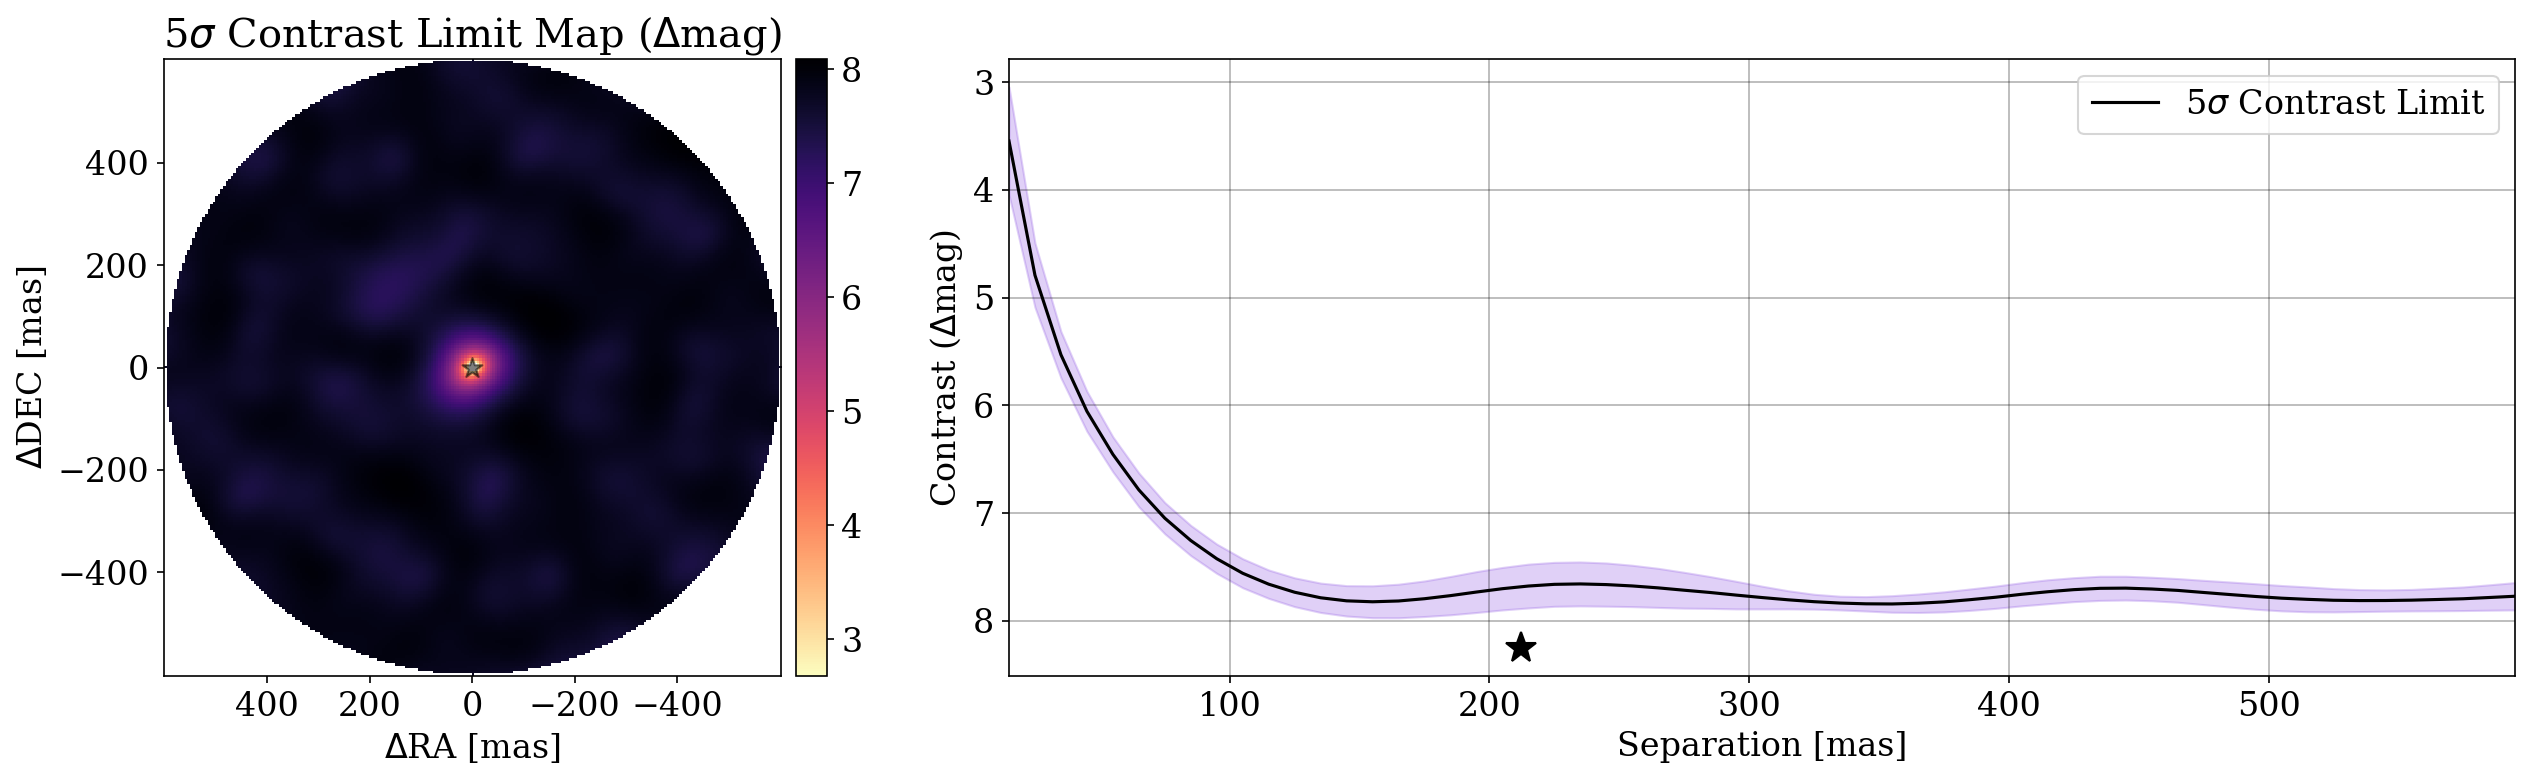

In [30]:
plt.figure(figsize=(20,5))
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 16})
plt.subplot(1,2,1)
plt.imshow(-2.5*jnp.log10(limits_rs[:,:]),cmap=matplotlib.colormaps['magma_r'],
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = 'None',alpha=1)
plt.colorbar(shrink=1, pad=0.01)
plt.scatter(0,0,marker='*',s=100,c='black',alpha=0.5)
plt.gca().invert_yaxis()
plt.title('5$\sigma$ Contrast Limit Map ($\\Delta$mag)')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.xticks([400,200,0,-200,-400])
plt.yticks([-400,-200,0,200,400])
plt.subplot(1,2,2)
plt.plot(rad_wdith*dx,avg_wdith,'-k',label="5$\sigma$ Contrast Limit")
plt.fill_between(rad_wdith*dx,avg_wdith - std_wdith,avg_wdith + std_wdith,color=(0.6,0.4,0.9),alpha=0.3)
plt.ylabel('Contrast ($\\Delta$mag)')
plt.xlabel('Separation [mas]')
plt.gca().invert_yaxis()
plt.xlim(np.nanmin(rad_wdith*dx+avg_wdith*0.),np.nanmax(rad_wdith*dx+avg_wdith*0.))
plt.grid(color='black',alpha=0.3)
plt.legend(loc='best')
plt.tight_layout(pad=0.)
plt.plot(jnp.sqrt(ddec_inp**2+dra_inp**2),-2.5*jnp.log10(p_inj_cont),marker='*',c='k',markersize=15)
plt.show()

# Do a comparison with the Absil method - functions are taken/adapted from Fouriever

In [31]:
ftol = 1e-3
sep_range = [10,500]
step_size=50
sigma=5
ndof = len(cp.flatten())+len(vis2.flatten())


def nsigma(chi2r_test,
           chi2r_true,
           ndof):
    """
    Parameters
    ----------
    chi2r_test: float
        Reduced chi-squared of test model.
    chi2r_true: float
        Reduced chi-squared of true model.
    ndof: int
        Number of degrees of freedom.
    
    Returns
    -------
    nsigma: float
        Detection significance.
    """
    
    q = stats.chi2.cdf(ndof*chi2r_test/chi2r_true, ndof)
    p = 1.-q
    nsigma = np.sqrt(stats.chi2.ppf(1.-p, 1.))
    if (p < 1e-15):
        nsigma = np.sqrt(stats.chi2.ppf(1.-1e-15, 1.))
    
    return nsigma

@jit
def vis_binary2(u, v, ddec,dra,p2,p3):
    #adapted from pymask
    ''' Calculate the complex visibilities observed by an array on a binary star
    ----------------------------------------------------------------
    - ddec = ddec (mas)
    - dra = dra (mas)
    - p2 = planet
    - p3 = star


    - u,v: baseline coordinates (wavelengths)
    ---------------------------------------------------------------- '''

    # relative locations
    ddec = (ddec)*np.pi/(180.*3600.*1000.)
    dra =  (dra)*np.pi/(180.*3600.*1000.)
    phi_r = jnp.cos(-2*np.pi*(u*dra + v*ddec))
    phi_i = jnp.sin(-2*np.pi*(u*dra + v*ddec))

    cvis = p3+p2*phi_r+p2*phi_i*1.0j

    return cvis

@jit
def chi2all(cp_modelr,v2_modelr,
            cp_obsr=cp.flatten(),
            vis2_obsr=vis2.flatten(),
            cp_errr=jnp.sqrt(cp_err**2).flatten(),
            vis2_errr=jnp.sqrt(vis2_err**2).flatten(),const=0.):
    
    # chi2 
    chi2_closurer = jnp.sum((cp_obsr - cp_modelr.flatten())**2 / cp_errr**2)

    chi2_v2r = jnp.sum((vis2_obsr - v2_modelr.flatten())**2 / (vis2_errr**2))

    return ( chi2_closurer+chi2_v2r) + const

#@jit
def chi2_suball(cont,vis_in,imsum,ddec,dra,u21=u,v21=v,
             i_cps121=i_cps1,
             i_cps221=i_cps2,i_cps321=i_cps3):
    cont = 10**cont
    cvis_t211 = vis_binary2(u21, v21, ddec = ddec,dra=dra,
                      p2=cont/(1.+cont+imsum),p3=1./(1.+cont+imsum))
    cvis_t211 += vis_in/(1+cont+imsum)
    cp_model_t211 = closure_phases(cvis_t211,i_cps121,i_cps221,i_cps321)
    return chi2all(cp_model_t211,jnp.abs(cvis_t211)**2)

def lim_absil(f0,
              ddec,
              dra,
              chi2_true,
              ndof,
              sigma=3):
    """
    Parameters
    ----------
    f0: float
        Relative flux of companion.
    func: method
        Method to compute chi-squared.
    p0: array
        p0[0]: float
            Relative flux of companion.
        p0[1]: float
            Right ascension offset of companion.
        p0[2]: float
            Declination offset of companion.
        p0[3]: float
            Uniform disk diameter (mas).
    data_list: list of dict
        List of data whose chi-squared shall be computed. The list
        contains one data structure for each observation.
    observables: list of str
        List of observables which shall be considered.
    cov: bool
        True if covariance shall be considered.
    smear: int
        Numerical bandwidth smearing which shall be used.
    chi2r_true: float
        Reduced chi-squared of true model.
    ndof: int
        Number of degrees of freedom.
    sigma: int
        Confidence level for which the detection limits shall be computed.

    Returns
    -------
    chi2: float
        Chi-squared of Absil method.
    """

    chi2_test = chi2_suball(f0,vis_in=0.,imsum=0.,ddec=ddec,dra=dra)
    nsigmavar = nsigma(chi2r_test=chi2_test/ndof,
                         chi2r_true=chi2_true/ndof,
                         ndof=ndof)

    return np.abs(nsigmavar-sigma)**2

null = chi2_suball(cont=-100,vis_in=0.,imsum=0.,ddec=0.,dra=0.)

In [32]:
grid_ra_dec, grid_sep_pa = get_grid(sep_range=sep_range,
                                             step_size=step_size,
                                             verbose=True)

sigma = int(sigma)
print('Computing detection limits ('+str(sigma)+'-sigma)')
f0s = np.linspace(-5., -1., 100)#np.logspace(-4, -1, 100)#
ffs_absil = []
nc = np.prod(grid_ra_dec[0].shape)
ctr = 0
for i in range(grid_ra_dec[0].shape[0]):
    for j in range(grid_ra_dec[0].shape[1]):
        ctr += 1
        if (ctr % 10 == 0):
            sys.stdout.write('\r   Cell %.0f of %.0f' % (ctr, nc))
            sys.stdout.flush()
        if ((np.isnan(grid_ra_dec[0][i, j]) == False) and 
            (np.isnan(grid_ra_dec[1][i, j]) == False)):
            
            p0 = np.array([f0s[0], grid_ra_dec[0][i, j], grid_ra_dec[1][i, j]])

            temp = [lim_absil(f0,p0[1],p0[2], null, ndof, sigma) for f0 in f0s]
            temp = np.array(temp)
            f0 = f0s[np.argmin(temp)]
            pp = minimize(lim_absil,
                          f0,
                          args=(p0[1],p0[2],null, ndof, sigma),
                          method='L-BFGS-B',
                          bounds=[(-6, 0)],
                          tol=ftol,
                          options={'maxiter': 100})
            ffs_absil += [pp['x'][0].copy()]
        else:
            ffs_absil += [np.nan]
sys.stdout.write('\r   Cell %.0f of %.0f' % (ctr, nc))
sys.stdout.flush()
print('')

ffs_absil = np.array(ffs_absil).reshape(grid_ra_dec[0].shape)

Computing grid
   Min. sep. = 50.0 mas
   Max. sep. = 500.0 mas
   316 non-empty grid cells
Computing detection limits (5-sigma)
   Cell 441 of 441


In [33]:
rad_t, avg_t = azimuthalAverage(-2.5*np.log10(10**ffs_absil), returnradii=True, binsize=1)
_, std_t = azimuthalAverage(-2.5*np.log10(10**ffs_absil), returnradii=True, binsize=1, stddev=True)

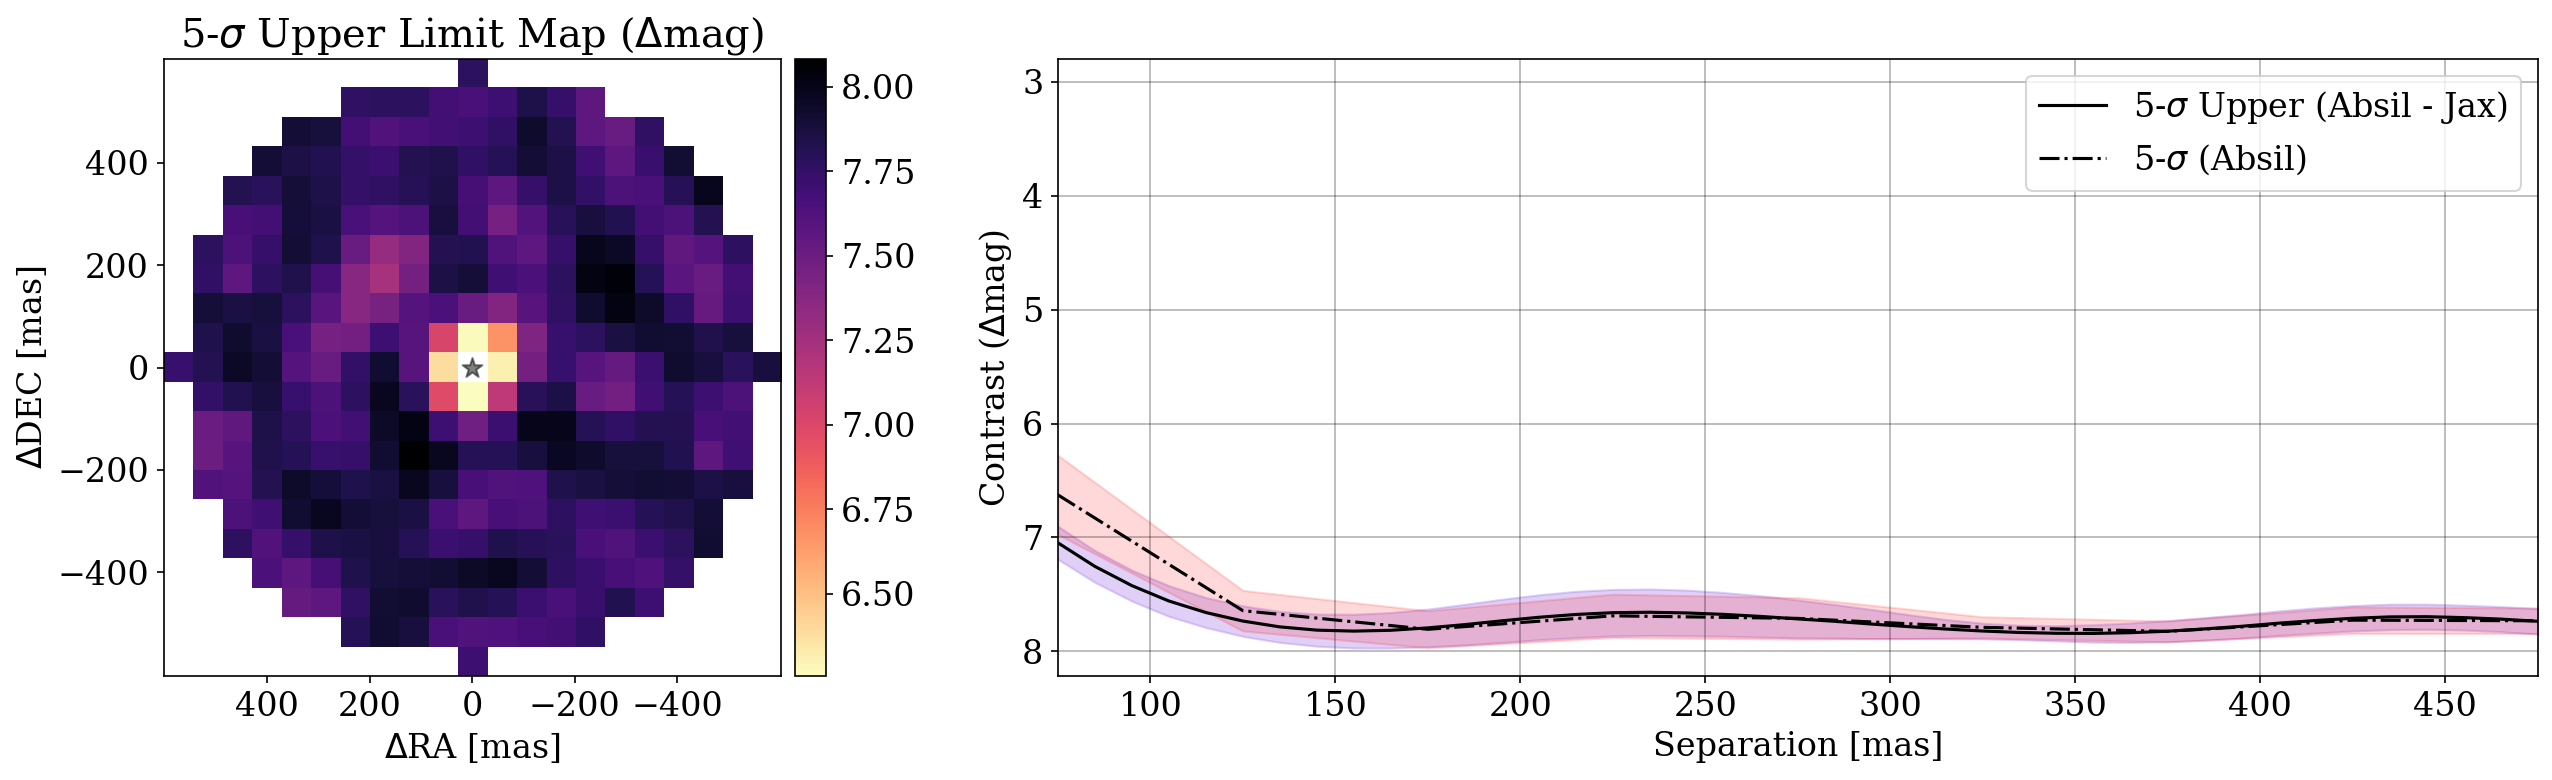

In [34]:
plt.figure(figsize=(20,5))
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 16})
plt.subplot(1,2,1)
plt.imshow(-2.5*jnp.log10(10**ffs_absil),cmap=matplotlib.colormaps['magma_r'],
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = 'None',alpha=1)
plt.colorbar(shrink=1, pad=0.01)
plt.scatter(0,0,marker='*',s=100,c='black',alpha=0.5)
plt.gca().invert_yaxis()
plt.title('5-$\\sigma$ Upper Limit Map ($\\Delta$mag)')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.xticks([400,200,0,-200,-400])
plt.yticks([-400,-200,0,200,400])
plt.subplot(1,2,2)
plt.plot(rad_wdith*dx,avg_wdith,'-k',label="5-$\\sigma$ Upper (Absil - Jax)")
plt.fill_between(rad_wdith*dx,avg_wdith - std_wdith,avg_wdith + std_wdith,color=(0.6,0.4,0.9),alpha=0.3)
plt.plot(rad_t*step_size,avg_t,linestyle='dashdot',c="k",label="5-$\\sigma$ (Absil)")
plt.fill_between(rad_t*step_size,avg_t - std_t,avg_t + std_t,color="red",alpha=0.15)
plt.ylabel('Contrast ($\\Delta$mag)')
plt.xlabel('Separation [mas]')
plt.gca().invert_yaxis()
#plt.xlim(np.nanmin(rad_wdith*dx+avg_wdith*0.),np.nanmax(rad_wdith*dx+avg_wdith*0.))
plt.xlim(np.nanmin(rad_t*step_size+avg_t*0.),np.nanmax(rad_t*step_size+avg_t*0.))
plt.grid(color='black',alpha=0.3)
plt.legend(loc='best')
plt.tight_layout(pad=0.)
plt.show()